In [1]:
#-*- coding: utf-8 -*-
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import math
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cPickle

from PIL import Image

import tensorflow.python.platform
from keras.preprocessing import sequence
from collections import Counter

import skimage
import skimage.io

class Caption_Generator():
    def init_weight(self, dim_in, dim_out, name=None, stddev=1.0):
        return tf.Variable(tf.truncated_normal([dim_in, dim_out], stddev=stddev/math.sqrt(float(dim_in))), name=name)

    def init_bias(self, dim_out, name=None):
        return tf.Variable(tf.zeros([dim_out]), name=name)

    def __init__(self, dim_image, dim_embed, dim_hidden, batch_size, n_lstm_steps, n_words, bias_init_vector=None):

        self.dim_image = np.int(dim_image)
        self.dim_embed = np.int(dim_embed)
        self.dim_hidden = np.int(dim_hidden)
        self.batch_size = np.int(batch_size)
        self.n_lstm_steps = np.int(n_lstm_steps)
        self.n_words = np.int(n_words)

        with tf.device("/cpu:0"):
            self.Wemb = tf.Variable(tf.random_uniform([n_words, dim_embed], -0.1, 0.1), name='Wemb')

        self.bemb = self.init_bias(dim_embed, name='bemb')

        self.lstm = tf.contrib.rnn.BasicLSTMCell(dim_hidden, state_is_tuple=False)

        #self.encode_img_W = self.init_weight(dim_image, dim_hidden, name='encode_img_W')
        self.encode_img_W = tf.Variable(tf.random_uniform([dim_image, dim_hidden], -0.1, 0.1), name='encode_img_W')
        self.encode_img_b = self.init_bias(dim_hidden, name='encode_img_b')

        self.embed_word_W = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1, 0.1), name='embed_word_W')

        if bias_init_vector is not None:
            self.embed_word_b = tf.Variable(bias_init_vector.astype(np.float32), name='embed_word_b')
        else:
            self.embed_word_b = self.init_bias(n_words, name='embed_word_b')

    def build_model(self):

        image = tf.placeholder(tf.float32, [self.batch_size, self.dim_image])
        sentence = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.n_lstm_steps])

        image_emb = tf.matmul(image, self.encode_img_W) + self.encode_img_b # (batch_size, dim_hidden)

        state = tf.zeros([self.batch_size, self.lstm.state_size])

        loss = 0.0
        with tf.variable_scope("RNN"):
            for i in range(self.n_lstm_steps): # maxlen + 1
                if i == 0:
                    current_emb = image_emb
                else:
                    with tf.device("/cpu:0"):
                        current_emb = tf.nn.embedding_lookup(self.Wemb, sentence[:,i-1]) + self.bemb

                if i > 0 : tf.get_variable_scope().reuse_variables()

                output, state = self.lstm(current_emb, state) # (batch_size, dim_hidden)

                if i > 0: # 이미지 다음 바로 나오는건 #START# 임. 이건 무시.
                    labels = tf.expand_dims(sentence[:, i], 1) # (batch_size)
                    indices = tf.expand_dims(tf.range(0, self.batch_size, 1), 1)
                    concated = tf.concat([indices, labels], 1)
                    onehot_labels = tf.sparse_to_dense(
                            concated, tf.stack([self.batch_size, self.n_words]), 1.0, 0.0) # (batch_size, n_words)

                    logit_words = tf.matmul(output, self.embed_word_W) + self.embed_word_b # (batch_size, n_words)
                    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit_words, labels=onehot_labels)
                    cross_entropy = cross_entropy * mask[:,i]#tf.expand_dims(mask, 1)

                    current_loss = tf.reduce_sum(cross_entropy)
                    loss = loss + current_loss

            loss = loss / tf.reduce_sum(mask[:,1:])
            return loss, image, sentence, mask

    def build_generator(self, maxlen):
        image = tf.placeholder(tf.float32, [1, self.dim_image])
        image_emb = tf.matmul(image, self.encode_img_W) + self.encode_img_b

        state = tf.zeros([1, self.lstm.state_size])
        #last_word = image_emb # 첫 단어 대신 이미지
        generated_words = []

        with tf.variable_scope("RNN"):
            output, state = self.lstm(image_emb, state)
            last_word = tf.nn.embedding_lookup(self.Wemb, [0]) + self.bemb

            for i in range(maxlen):
                tf.get_variable_scope().reuse_variables()

                output, state = self.lstm(last_word, state)

                logit_words = tf.matmul(output, self.embed_word_W) + self.embed_word_b
                max_prob_word = tf.argmax(logit_words, 1)

                with tf.device("/cpu:0"):
                    last_word = tf.nn.embedding_lookup(self.Wemb, max_prob_word)

                last_word += self.bemb

                generated_words.append(max_prob_word)

        return image, generated_words

def get_caption_data(annotation_path, feat_path):
     feats = np.load(feat_path)
     annotations = pd.read_table(annotation_path, sep='\t', header=None, names=['image', 'caption'])
     captions = annotations['caption'].values

     return feats, captions

def preProBuildWordVocab(sentence_iterator, word_count_threshold=30): # borrowed this function from NeuralTalk
    print 'preprocessing word counts and creating vocab based on word count threshold %d' % (word_count_threshold, )
    word_counts = {}
    nsents = 0
    for sent in sentence_iterator:
      nsents += 1
      for w in sent.lower().split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    print 'filtered words from %d to %d' % (len(word_counts), len(vocab))

    ixtoword = {}
    ixtoword[0] = '.'  # period at the end of the sentence. make first dimension be end token
    wordtoix = {}
    wordtoix['#START#'] = 0 # make first vector be the start token
    ix = 1
    for w in vocab:
      wordtoix[w] = ix
      ixtoword[ix] = w
      ix += 1

    word_counts['.'] = nsents
    bias_init_vector = np.array([1.0*word_counts[ixtoword[i]] for i in ixtoword])
    bias_init_vector /= np.sum(bias_init_vector) # normalize to frequencies
    bias_init_vector = np.log(bias_init_vector)
    bias_init_vector -= np.max(bias_init_vector) # shift to nice numeric range
    return wordtoix, ixtoword, bias_init_vector

def crop_image(x, target_height=227, target_width=227, as_float=True):
    #image = skimage.img_as_float(skimage.io.imread(x)).astype(np.float32)
    image = skimage.io.imread(x)
    if as_float:
        image = skimage.img_as_float(image).astype(np.float32)

    if len(image.shape) == 2:
        image = np.tile(image[:,:,None], 3)
    elif len(image.shape) == 4:
        image = image[:,:,:,0]

    height, width, rgb = image.shape
    if width == height:
        resized_image = cv2.resize(image, (target_height,target_width))

    elif height < width:
        resized_image = cv2.resize(image, (int(width * float(target_height)/height), target_width))
        cropping_length = int((resized_image.shape[1] - target_height) / 2)
        resized_image = resized_image[:,cropping_length:resized_image.shape[1] - cropping_length]

    else:
        resized_image = cv2.resize(image, (target_height, int(height * float(target_width) / width)))
        cropping_length = int((resized_image.shape[0] - target_width) / 2)
        resized_image = resized_image[cropping_length:resized_image.shape[0] - cropping_length,:]

    return cv2.resize(resized_image, (target_height, target_width))

################### 학습 관련 Parameters #####################

dim_embed = 256
dim_hidden = 256
dim_image = 4096
batch_size = 128

#learning_rate = 0.001
n_epochs = 10
###############################################################
#################### 잡다한 Parameters ########################
model_path = './models'
vgg_path = './data/vgg16.tfmodel'
data_path = './data'
feat_path = './data/feats.npy'
annotation_path = os.path.join(data_path, 'results_20130124.token')
################################################################


def train():

    learning_rate = 0.001
    momentum = 0.9
    feats, captions = get_caption_data(annotation_path, feat_path)
    wordtoix, ixtoword, bias_init_vector = preProBuildWordVocab(captions)

    np.save('data/ixtoword', ixtoword)
    np.save('data/wordtoix', wordtoix)

    index = np.arange(len(feats))
    np.random.shuffle(index)

    feats = feats[index]
    captions = captions[index]

    sess = tf.InteractiveSession()
    n_words = len(wordtoix)
    maxlen = np.max( map(lambda x: len(x.split(' ')), captions) )
    caption_generator = Caption_Generator(
            dim_image=dim_image,
            dim_hidden=dim_hidden,
            dim_embed=dim_embed,
            batch_size=batch_size,
            n_lstm_steps=maxlen+2,
            n_words=n_words,
            bias_init_vector=bias_init_vector)

    loss, image, sentence, mask = caption_generator.build_model()

    saver = tf.train.Saver(max_to_keep=50)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    tf.initialize_all_variables().run()
    for epoch in range(n_epochs):
        #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        for start, end in zip( \
                range(0, len(feats), batch_size),
                range(batch_size, len(feats), batch_size)
                ):
            current_feats = feats[start:end]
            current_captions = captions[start:end]

            current_caption_ind = map(lambda cap: [wordtoix[word] for word in cap.lower().split(' ')[:-1] if word in wordtoix], current_captions)

            current_caption_matrix = sequence.pad_sequences(current_caption_ind, padding='post', maxlen=maxlen+1)
            current_caption_matrix = np.hstack( [np.full( (len(current_caption_matrix),1), 0), current_caption_matrix] ).astype(int)

            current_mask_matrix = np.zeros((current_caption_matrix.shape[0], current_caption_matrix.shape[1]))
            nonzeros = np.array( map(lambda x: (x != 0).sum()+2, current_caption_matrix ))
            #  +2 -> #START# and '.'

            for ind, row in enumerate(current_mask_matrix):
                row[:nonzeros[ind]] = 1

            _, loss_value = sess.run([train_op, loss], feed_dict={
                image: current_feats,
                sentence : current_caption_matrix,
                mask : current_mask_matrix
                })

            print "Current Cost: ", loss_value, ", Epoch: ", epoch, ", iteration: ", start, "/", len(feats) 

        print "Epoch ", epoch, " is done. Saving the model ... "
        saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch)
        learning_rate *= 0.95

def test(test_feat='./guitar_player.npy', model_path='./models/tensorflow/model-1', maxlen=30): # Naive greedy search

    ixtoword = np.load('data/ixtoword.npy').tolist()
    n_words = len(ixtoword)

    feat = [np.load(test_feat)]
    sess = tf.InteractiveSession()
    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    image, generated_words = caption_generator.build_generator(maxlen=maxlen)
    # 이 부분이 중요함. 계속 caption_generator를 가져온 뒤 바로 restore를 했었는데,
    # TensorFlow의 LSTM은 call을 한 뒤에 weight가 만들어지기 때문에 build_generator보다 뒤쪽에서 restore를 해야 함.
    saver = tf.train.Saver()
    saver.restore(sess, model_path)

    generated_word_index= sess.run(generated_words, feed_dict={image:feat})
    generated_word_index = np.hstack(generated_word_index)

    generated_sentence = [ixtoword[x] for x in generated_word_index]


def read_image(path):

     img = crop_image(path, target_height=224, target_width=224)
     if img.shape[2] == 4:
         img = img[:,:,:3]

     img = img[None, ...]
     return img

def test_100(test_image_path='flickr30k', model_path='./models/model-10', maxlen=30):
    with open(vgg_path) as f:
        fileContent = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(fileContent)
        
    images = tf.placeholder("float32", [1, 224, 224, 3])
    tf.import_graph_def(graph_def, input_map={"images":images})

    ixtoword = np.load('./data/ixtoword.npy').tolist()
    n_words = len(ixtoword)
    
    filename = np.array(os.listdir(test_image_path))
    np.random.shuffle(filename)
    filename = filename[0:100]

    sess = tf.InteractiveSession()

    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    graph = tf.get_default_graph()
    fc7_tf, generated_word = caption_generator.build_generator(maxlen=maxlen)

    saver = tf.train.Saver()
    saver.restore(sess, model_path)
     
    for image in filename:
        image_val = read_image(os.path.join(test_image_path, image))
        
        fc7 = sess.run(graph.get_tensor_by_name("import/fc7_relu:0"), feed_dict={images:image_val})
        
        generated_word_index= sess.run(generated_word, feed_dict={fc7_tf:fc7})
        generated_word_index = np.hstack(generated_word_index)

        generated_words = [ixtoword[x] for x in generated_word_index]
        punctuation = np.argmax(np.array(generated_words) == '.')+1

        generated_words = generated_words[:punctuation]
        generated_sentence = ' '.join(generated_words)
        
        PIL_image = Image.open(os.path.join(test_image_path, image))
        fig,ax=plt.subplots(1,1)
        ax.imshow(PIL_image)
        plt.show()

        print generated_sentence

def test_tf(test_image_path=None, model_path='./models/model-72', maxlen=30):
    with open(vgg_path) as f:
        fileContent = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(fileContent)

    images = tf.placeholder("float32", [1, 224, 224, 3])
    tf.import_graph_def(graph_def, input_map={"images":images})

    ixtoword = np.load('./data/ixtoword.npy').tolist()
    n_words = len(ixtoword)

    image_val = read_image(test_image_path)
    sess = tf.InteractiveSession()

    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    graph = tf.get_default_graph()
    fc7 = sess.run(graph.get_tensor_by_name("import/fc7_relu:0"), feed_dict={images:image_val})

    fc7_tf, generated_words = caption_generator.build_generator(maxlen=maxlen)

    saver = tf.train.Saver()
    saver.restore(sess, model_path)

    generated_word_index= sess.run(generated_words, feed_dict={fc7_tf:fc7})
    generated_word_index = np.hstack(generated_word_index)

    generated_words = [ixtoword[x] for x in generated_word_index]
    punctuation = np.argmax(np.array(generated_words) == '.')+1

    generated_words = generated_words[:punctuation]
    generated_sentence = ' '.join(generated_words)
    print generated_sentence



Using TensorFlow backend.


In [2]:
def bleu_1(reference, candidate):
    #print reference, candidate
    prec = [x for x in candidate if x in reference] 
    bleu1 = float(len(prec)) / len(candidate)
    return bleu1

def bleu_2(reference, candidate):
    bi_gram_cand = zip(candidate, candidate[1:])
    bi_gram_ref = zip(reference, reference[1:])
    prec = [[x,y] for x,y in bi_gram_cand if (x,y) in bi_gram_ref]
    bleu2 = float(len(prec)) / len(bi_gram_cand)
    return bleu2
                
def bleu_3(reference, candidate):
    tri_gram_cand = zip(candidate, candidate[1:], candidate[2:])
    tri_gram_ref = zip(reference, reference[1:], reference[2:])
    prec = [[x,y,z] for x,y,z in tri_gram_cand if (x,y,z) in tri_gram_ref]
    bleu3 = float(len(prec)) / len(tri_gram_cand)
    return bleu3

def bleu_4(reference, candidate):
    quad_gram_cand = zip(candidate, candidate[1:], candidate[2:], candidate[3:])
    quad_gram_ref = zip(reference, reference[1:], reference[2:], reference[3:])
    prec = [[x,y, z, w] for x,y, z, w in quad_gram_cand if (x,y,w,z) in quad_gram_ref]
    bleu4 = float(len(prec)) / len(quad_gram_cand)
    return bleu4
    
def meteor(reference, candidate):
    matches = [x for x in candidate if x in reference]
    chunks = [ candidate[i] for i in range(min(len(reference), len(candidate))) if candidate[i]==reference[i] ]
    if len(candidate) == 0 or len(reference) == 0:
        return 0
    P = float(len(matches)) / len(candidate)
    R = float(len(matches)) / len(reference)
    if P == 0 or R == 0:
        return 0
    
    Fmean = 10*P*R / (R+9*P)
    Penalty = 0.5*pow(len(chunks)/ len(matches), 3)
    Score = Fmean*(1-Penalty)
    return Score
    

In [3]:
def test_and_eval(test_image_path='flickr30k_test', model_path='./models/model-10', maxlen=30):
    with open(vgg_path) as f:
        fileContent = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(fileContent)
    
    annotations = pd.read_table(annotation_path, sep='\t', header=None, names=['image', 'caption'])
    captions = annotations['caption'].values
    n_samples = len(captions)
    
    images = tf.placeholder("float32", [1, 224, 224, 3])
    tf.import_graph_def(graph_def, input_map={"images":images})

    ixtoword = np.load('./data/ixtoword.npy').tolist()
    wordtoix = np.load('./data/wordtoix.npy').tolist()
    n_words = len(ixtoword)
    
    filename = np.array(os.listdir(test_image_path))
    np.random.shuffle(filename)
    filename = filename[:2000]

    sess = tf.InteractiveSession()

    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    graph = tf.get_default_graph()
    fc7_tf, generated_word = caption_generator.build_generator(maxlen=maxlen)

    saver = tf.train.Saver()
    saver.restore(sess, model_path)
    
    sample_cnt = 0
    bleu1 = 0.0 ; bleu2 = 0.0 ; bleu3 = 0.0 ; bleu4 = 0.0 ; Meteor = 0.0
    for image in filename:
        sample_cnt += 1
        image_val = read_image(os.path.join(test_image_path, image))
        # the name of i-th caption of n-th image : 'n.jpg#i'
        
        fc7 = sess.run(graph.get_tensor_by_name("import/fc7_relu:0"), feed_dict={images:image_val})
        
        generated_word_index= sess.run(generated_word, feed_dict={fc7_tf:fc7})
        generated_word_index = np.hstack(generated_word_index)
        
        generated_words = [ixtoword[x] for x in generated_word_index]
        punctuation = np.argmax(np.array(generated_words) == '.')+1
        
        generated_word_index = generated_word_index[:punctuation-1]
        generated_words = generated_words[:punctuation]
        generated_sentence = ' '.join(generated_words)
        
        cap_ids = [np.where(annotations['image'].values == y)[0][0] for y in \
                   filter(lambda x: image in x, annotations['image'].values)]
        
        gt_words_index = []
        Met = []
        for i in range(len(cap_ids)):
            gt_sentence = annotations['caption'].values[cap_ids[i]]
            gt_word_index = [wordtoix[word] for word in gt_sentence.lower().split(' ')[:-1] if word in wordtoix]
            gt_words_index = gt_words_index + gt_word_index + [0]
            Met = Met + [meteor(gt_word_index, generated_word_index)] 
        
        Meteor = Meteor + max(Met)
        bleu1 = bleu1 + bleu_1(gt_words_index, generated_word_index)
        bleu2 = bleu2 + bleu_2(gt_words_index, generated_word_index)
        bleu3 = bleu3 + bleu_3(gt_words_index, generated_word_index)
        bleu4 = bleu4 + bleu_4(gt_words_index, generated_word_index)
        # bleu1 /= len(cap_ids) ; bleu2 /= len(cap_ids) ; bleu3 /= len(cap_ids) ; bleu4 /= len(cap_ids) 
        
        #if sample_cnt % 100 == 0:
        #    print "%04d-th sample" % sample_cnt
        if sample_cnt % 100 == 0:
            PIL_image = Image.open(os.path.join(test_image_path, image))
            fig,ax=plt.subplots(1,1)
            ax.imshow(PIL_image)
            plt.show()

            print generated_sentence
            
    bleu1 /= sample_cnt ; bleu2 /= sample_cnt ; bleu3 /= sample_cnt ; bleu4 /= sample_cnt ; Meteor /= sample_cnt
    print "----------------------- Evaluation Results --------------------------"
    print "BLEU 1 :", bleu1, "\nBLEU 2 :", bleu2, "\nBLEU 3 :", bleu3, "\nBLEU 4 :", bleu4 

In [4]:
do_train = False
if do_train:
    train()

INFO:tensorflow:Restoring parameters from ./models/model-9
[1132, 1665, 601, 1132]
[1132, 573, 1665, 1589, 1132]
[1132, 573, 601, 1132]
[1132, 573, 1665, 1132]
[1132, 1665, 1589, 1132]
[1132, 2469, 2462, 1132]
[1740, 2469, 2462]
[1740, 2462, 2483]
[1132, 1740, 2469, 2462, 2483, 1132]
[1132, 2462, 1783, 2483, 1132]
[1132, 1132, 2722, 280, 974, 1132]
[1132, 1691, 1132, 2722, 1589, 280, 974, 1132, 2221]
[1132, 1592, 1132, 2722, 1589, 280, 974, 1132]
[1132, 1691, 1592, 1132, 2722, 280, 974, 1132]
[280, 974]
[1132, 1691, 1592, 1132, 2722, 1589, 1132]
[1132, 1691, 1592, 1132, 2722, 1132]
[1132, 1691, 1592, 1132, 1132]
[1132, 1691, 1132, 1132]
[1132, 1691, 1132, 1132]
[]
[1132, 1665, 1132, 601, 1132]
[]
[]
[]
[1132, 1691, 1592, 1132, 1592, 1132]
[1132, 1691, 1132, 1132]
[1132, 1691, 1132, 1589, 1132]
[1132, 1691, 1592, 1132, 1592, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1691, 1592, 1132, 2722, 1589, 1132, 1302]
[1132, 1691, 1592, 1132, 1589, 1132, 1302]
[1132, 1691, 1132, 113

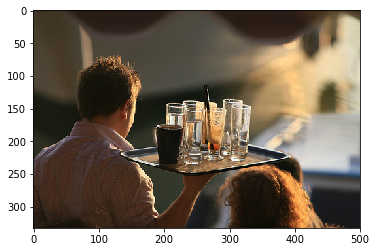

a man in a white shirt is sitting at a table with a large piece of paper in his hands .
[1132, 2585, 1592, 1132, 1589, 1132]
[1132, 1592, 1132, 2469, 1132]
[2585, 1592, 1589]
[1132, 1592, 1132, 1132]
[1132, 1132, 1589, 1132]
[1132, 1592, 1132, 1132]
[]
[1132, 1132, 974, 1132]
[1132, 1132, 1132]
[]
[1132, 1592, 1132, 280, 974, 1132, 2221]
[1132, 1592, 1132, 2095, 974, 1132, 2221]
[1592, 280]
[1132, 1132, 974, 1132, 2221]
[280, 974]
[1132, 1691, 1132, 354, 1132]
[1132, 1691, 601, 1132, 1132]
[1132, 1691, 1589, 1132, 772, 1132]
[1132, 1691, 601, 1132, 772, 1132]
[1132, 1132, 772, 1132]
[1132, 1132, 1589, 1320, 1132]
[1132, 1592, 1132, 1592, 1132]
[1132, 1592, 1132, 1592, 1132]
[1132, 1592, 1132, 1592, 1132]
[1132, 1592, 1132, 1592, 1132]
[1132, 1691, 1592, 1132, 1589, 1132]
[1132, 1691, 1592, 1132, 134, 1132]
[1132, 1691, 1592, 1132, 134, 1589, 1132]
[1132, 1691, 1132, 134, 1589, 1132]
[1132, 1691, 1132, 1589, 1132]
[1132, 1132]
[573]
[]
[]
[]
[1132, 2585, 1592, 1132, 1888]
[1132, 1132, 1

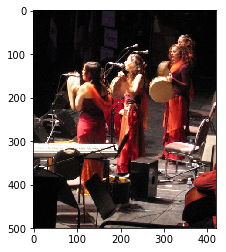

a man in a black shirt is playing a guitar .
[1132, 1592, 1132, 601, 1132, 1304, 1132, 1592, 1329, 2547]
[601, 1304, 2547]
[1132, 1592, 1132, 601, 1132, 1304, 1132, 1592, 1329, 2547]
[1132, 1592, 1132, 601, 1132, 1304, 1132, 1592, 1329, 2547]
[1132, 1132, 601, 1132, 1304, 1132]
[1132, 1132, 601, 1132]
[1132, 1691, 1589, 680, 1132, 1132, 1159]
[1132, 1691, 1132, 601, 1132]
[1132, 1691, 1589, 1132, 1132]
[1132, 1132, 1132, 1159]
[1132, 1691, 1592, 1132, 1132]
[1132, 1132, 1132]
[1132, 1691, 1132, 1132]
[1132, 1691, 1132, 1132]
[1132, 1132, 1132]
[1132, 1691, 1132, 1132]
[1132, 1691, 1132, 1132]
[1132, 1691, 1592, 1132, 1589, 1132]
[1132, 1691, 1132, 1132]
[1691]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1589, 1132]
[1132, 1592, 1132, 1132]
[1132, 1691, 1592, 1132, 1132]
[1592]
[1132, 1132, 1132]
[]
[1132, 1132, 1132]
[1592, 1592, 1329, 2547]
[1132, 1132, 1132]
[1132, 1592, 1132, 1132, 2100, 1132]
[1132, 1691, 1592, 1132, 1132, 2100, 1132]
[1132, 1132, 680, 1132, 2100, 1132]
[1132, 1691

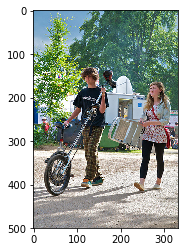

a woman in a red shirt is riding a bicycle down a street .
[1132, 1691, 1132, 974, 1132]
[1132, 1132, 1132]
[1132, 1691, 1592, 1132, 1589, 974, 1132]
[1589]
[1132, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1132, 2722, 1589, 1132]
[1132, 1691, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1691, 1132, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1589]
[1132, 1592, 1132, 2223]
[1132, 1592, 1132, 2223]
[1132, 1132, 2223, 1589]
[1132, 1132]
[1132, 1740, 2469, 2462, 1545, 1589, 859, 2559]
[1132, 1545, 2483, 859, 2559]
[1132, 1545, 1783, 2483]
[1132, 1740, 2469, 2462, 1545, 859]
[1132, 1545, 2559]
[1132, 1589, 1132, 1159]
[1132, 1132]
[1132, 1691, 1589, 280, 1132, 1159, 1819]
[1132, 1132, 1159, 1819]
[1132, 1691, 1132]
[1132, 1592, 1132, 2095, 2722, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132, 67]
[1592]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 597, 1592, 1329, 2547, 1132, 2659]
[

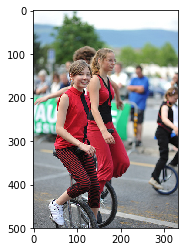

a woman in a white shirt and a woman in a white shirt are walking down the street .
[1132, 72, 1132, 601, 1132]
[1132, 1589, 1132, 1132]
[1132, 645, 1132, 601, 1132]
[1132, 1132, 601, 1132]
[1132, 1132, 1132]
[1132, 1691, 1132, 1132]
[1132, 1691, 1132, 354, 1132]
[1132, 1132, 2221, 1132]
[1132, 1691, 1132, 1132, 390]
[1132, 1691, 1589, 1132, 354, 1132]
[1132, 1691, 1589]
[1132, 1691, 1589]
[1132, 1691]
[1132, 1589, 1888]
[1132]
[1132, 1589, 1132, 1836, 2547]
[1132, 1589, 1132, 1836]
[1589]
[1132, 1132, 1836]
[1132, 1132, 1836]
[1132, 1691, 1592, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 601, 1132]
[1132, 1691, 1132, 1589, 1132]
[1132, 1691, 1132, 1589, 1132]
[1132, 1740, 1545, 601, 859]
[1545, 859]
[1132, 1740, 1545, 1589, 859]
[1132, 1740, 1545]
[1132, 1740, 1545, 601, 859]
[1132, 1592, 1132, 2469, 1132, 1132]
[1132, 1592, 1132, 1132, 680, 1132, 2217]
[1132, 1132, 1132, 680, 1132, 2217]
[1132, 1132, 1132, 1132, 2217]
[1132, 1592, 1132, 1132, 680, 1132]
[]
[1132, 1592, 1132, 1132, 25

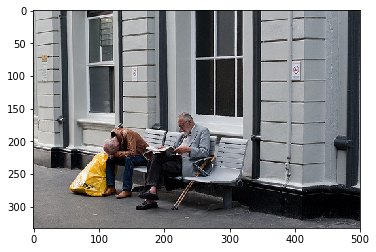

a man in a black shirt is walking down a street .
[1132, 1691, 1592, 1132, 1589, 1132, 2351]
[1132, 1592, 1132, 1589, 900, 1132]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1740, 2722, 1132]
[1132, 1592, 1132, 1132, 2221]
[1132, 1132, 1740, 1589, 1132, 2221]
[1132, 1592, 1132, 1132, 2221]
[1132, 1132, 1589, 1132]
[1132, 603, 1589, 601, 1132]
[1132, 601, 1132]
[1132, 603, 1589, 1771, 601, 1132]
[1132, 603, 1589, 1771, 1132]
[1132, 603, 1132]
[1132, 1691, 1589, 1132, 2547, 1132, 2547]
[1132, 1132, 1592, 2547, 1132, 2547]
[1132, 1691, 1132, 2547, 1132, 2547]
[1132, 1691, 1132, 1132]
[1691, 1592, 2419]
[1132, 1132, 1132]
[1132, 1691, 1592, 1132, 1132]
[1132, 1592, 1132, 1132]
[2221]
[1132, 1132, 1132]
[]
[1132, 1589, 1132]
[]
[1132, 1589, 1132]
[1132, 1132]
[1132, 1691, 1592, 1132, 1589, 1592, 1132, 1132]
[1132, 1592, 1132, 2722, 1592, 1132, 1132]
[1132, 1691, 1132, 1589, 1132, 1132]
[1132, 1691, 1592, 1132, 2722, 1589, 1592, 1132, 1132]
[1132, 1592, 1

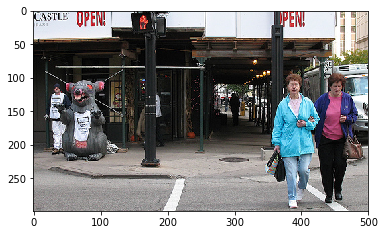

a man in a black shirt is walking down the street .
[1132, 1691, 1592, 1132, 2722, 1589]
[1132, 1132]
[1132, 1691, 1132, 1589]
[1132, 1691, 1132, 1589]
[1132, 1691, 1132, 1589]
[1132, 1132, 1846, 601, 1132, 354, 1132]
[1132, 1132, 601, 1132, 354, 1132]
[1132, 2585, 1132, 1846, 601, 1132, 1132]
[1132, 1132, 1846, 1132, 1132]
[1592, 1846]
[1132, 1132, 1132, 1589, 900, 1132]
[2469, 2469]
[2469, 2469]
[2469, 2469]
[1132, 1132, 1132, 1132]
[1132, 1592, 1132, 2722, 1589, 1132, 354, 1132, 1592]
[1132, 1592, 1132, 2722, 365, 1132, 714, 1132, 1592, 351]
[1132, 1132, 1132, 354, 1132]
[1132, 1592, 1132, 1132, 1132, 1592]
[1132, 1592, 1132, 1132, 1132, 1592]
[1132, 1132, 1589, 1132, 1708]
[1132, 1691, 1592, 1132, 1589, 1132, 1708]
[1132, 1132, 1132, 1708]
[1132, 1132, 1132, 1708]
[1132, 1132, 1132]
[1132, 1132, 1589, 1132, 354, 1132]
[1132, 1132, 1132, 354, 1132]
[1132, 1592, 1132, 1132, 354, 1132]
[1132, 1132, 1132, 354, 1132]
[1132, 1132, 1589, 1132, 354, 1132]
[1132, 1592, 1132]
[1132, 1592, 11

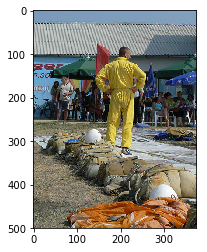

a man in a hat is standing on a horse .
[1691, 1592, 1589]
[1132, 1691, 1132, 1132]
[1132, 1691, 1592, 1132, 1132]
[1691]
[1132, 1691, 1132, 1132]
[1132, 1132, 1132]
[]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 1132]
[1592, 1888]
[1592, 1888]
[1592, 1888]
[1592, 1888]
[1132, 1132, 2547, 1132, 2095]
[1132, 1132, 2547, 1132]
[1132, 1132, 1589, 1132]
[1592, 1592]
[1132, 1132, 1132]
[2223, 2722, 1589]
[1132, 1132, 1589, 1132]
[1132, 1132, 1132]
[]
[1132, 1132, 1132]
[1132, 1132, 1589, 900, 1132]
[1132, 2585, 1132, 900, 1132]
[1132, 2585, 1132, 900, 1132]
[1132, 2585, 1132, 1132]
[1132, 2585, 1132, 1132]
[]
[1132, 2547, 1132]
[1132, 1132]
[1132, 1132]
[1132, 1132]
[1132, 1132, 1740, 1132]
[1132, 2585, 1592, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[2420]
[1132, 1592, 1132, 2469, 1132, 2420, 1132, 1244]
[1132, 1592, 1132, 1132, 2420, 1132, 1244]
[1132, 1132, 2469, 1132, 1132]
[1132, 1132, 1132, 2420, 1132]
[1132, 1592, 1132, 1592,

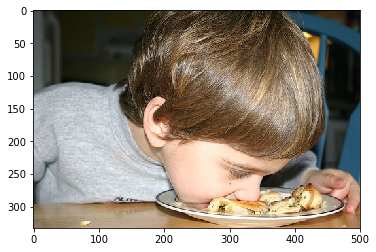

a woman is a small child in a kitchen .
[1132, 1132, 2462, 1589, 1132, 1096, 354, 1132]
[1132, 1691, 1592, 1132, 1589, 1592, 1329, 2547, 1132, 1132]
[1132, 1691, 1132, 1589, 1132, 1132]
[1132, 1132, 1132, 354, 1132, 601]
[1132, 1691, 1132, 1132, 354, 1132]
[1592, 1589]
[1132, 1691, 1132, 1589, 1888, 1132]
[1132, 1132, 1132]
[1132, 1691, 1592, 1132, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 2223]
[1132, 1691, 1592, 1132, 1589]
[1132, 1592, 1132, 1589]
[1132, 1132]
[1132, 1132, 1589]
[1132, 1132, 1132]
[1132, 1132, 1846, 601, 1132]
[1846]
[1846]
[1846]
[1132, 573, 1132]
[1132, 1132]
[573]
[1132, 1132]
[1132, 1589, 1132]
[1132, 1691, 1592, 1132, 1589, 1846, 1132]
[1132, 1691, 1132, 1846, 1132]
[]
[]
[1132, 1691, 1132, 1132]
[1132, 1592, 1132, 597, 601, 1132]
[1132, 1592, 1132, 1589, 1132]
[1132, 1592, 1132, 1132]
[1132, 1691, 1132, 597, 1132]
[1132, 1132, 1132]
[]
[1132, 1132, 1132, 1132]
[]
[1132, 1132, 1132, 1132]
[]
[1132, 1592, 1132, 1589, 1132]
[1132, 1691, 1132, 1132]
[1132, 1691,

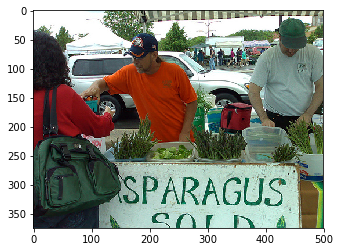

a man in a blue shirt is working on a machine .
[1132, 1709, 1592, 1132, 1592, 1132]
[1132, 1132, 1132]
[1132, 1132, 2722, 1132]
[1132, 1132, 2722, 1132]
[1132, 1592, 1132, 1589, 1592, 1132]
[1132, 1132, 1132, 2547]
[1132, 1589, 1132, 1132, 2547]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 2221]
[1132, 1592, 1132, 859]
[1132, 1132, 1589]
[1132, 1132, 2221]
[1132, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 2469, 1589, 1888, 354, 1132]
[1132, 1592, 1132, 1132]
[1132, 1691, 1132, 1132]
[1132, 1132, 1888, 1132]
[1691, 1592]
[1132, 1691, 1592, 1132, 1132, 1171]
[1592]
[1132, 1691, 1132, 1132]
[1691, 1592]
[1132, 1589, 1132]
[1132, 1132]
[1132, 1691, 601, 1132]
[1132, 1691, 1132]
[1132, 1691, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 1132, 1592]
[1132, 1691, 1132, 597, 1132]
[1132, 1691, 1592, 1132, 1592, 1132]
[1132, 1691, 1592, 1132, 1592, 1132]
[1132, 1691, 1592, 1132, 597, 1592, 1132]
[1132, 1592,

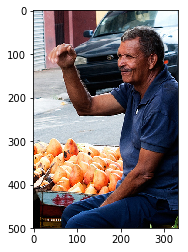

a man in a blue shirt is working on a piece of equipment .
[1132, 1132, 1132, 1132]
[1132, 1132, 1132, 1132]
[1132, 1132, 1132, 1132]
[1132, 1132, 1132, 1132]
[1132, 1132, 1132, 1132]
[1132, 1132, 597, 601, 1132]
[1132, 1592, 1132, 601, 1132]
[1132, 1132, 1132]
[1132, 1132, 597, 601, 1132]
[1132, 1132, 601, 1132]
[1132, 1691, 1589, 1132, 1132]
[1691, 1589]
[1132, 1691, 1589, 1132, 601, 1132]
[1132, 1691, 1589, 1132, 601, 1132]
[1691]
[1132, 1691, 1132, 2469, 1132, 1132, 2462, 2693, 1132]
[1132, 1691, 1132, 2469, 1132, 1132, 2693, 1132]
[1132, 1691, 1132, 1132, 1132, 1132]
[1691]
[1132, 1691, 1132, 2469, 1132, 1132, 2693, 1132]
[1132, 1592, 1132, 2095, 1132]
[1132, 1132, 1132]
[1592]
[1132, 1592, 1132, 1132]
[1132, 1132, 2722, 1132]
[1132, 603, 1589, 114, 1592, 1132, 603]
[1132, 603, 1589, 1132, 603]
[1132, 603, 1132, 603]
[1132, 603, 1592, 1132, 603]
[1132, 603, 1592, 1132, 603]
[1132, 1132, 859]
[1132, 1132, 859]
[1132, 1691, 1589, 1132, 859]
[1132, 1589, 1132]
[]
[1132, 1545, 1592, 1

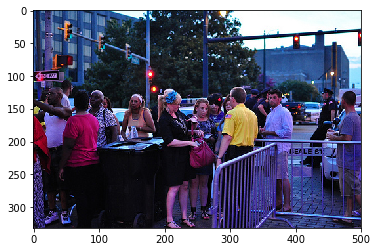

a man in a white shirt is walking down a street .
[859]
[1132, 859, 1132]
[601, 772]
[1132, 601, 859, 1132]
[1132, 601, 859, 1132]
[1132, 1589, 1846, 601, 1132]
[1132, 1132]
[1132, 1132]
[]
[1132, 1132]
[1132, 1691, 1592, 1132, 2722, 1132]
[1132, 1691, 1132, 1740, 2722, 1132]
[1132, 1592, 1132, 1740, 2722, 1132]
[1132, 1691, 1592, 1132, 1740, 2722, 1589, 1132]
[1132, 1132, 1589, 1132]
[1132, 1132, 1044, 601, 1132]
[1132, 1132, 601, 1132]
[1132, 1589, 1132, 601, 1132]
[1132, 1589, 1132, 1132]
[1132, 1589, 1132, 601, 1132]
[1132, 1691, 1592, 1132, 2722, 1132]
[1132, 1691, 1132, 2722, 1132]
[1132, 1691, 1132, 1589, 1132]
[1132, 1691, 1592, 1132, 2722, 1589, 1132]
[1132, 1691, 1592, 1132, 2722, 1132]
[1132, 1592, 1132, 2462, 1589, 1592, 1329, 2547, 1132, 1132]
[1132, 1592, 1132, 1592, 2547, 1132, 1096, 1132]
[1132, 1132, 2547, 1132, 1132]
[1132, 1592, 1132, 2462, 1592, 1132, 1132]
[1132, 1132, 2547, 1132, 1132]
[1132, 1592, 1132, 1589, 1132]
[1132, 1132, 1132]
[1132, 1132, 1589, 1132]
[113

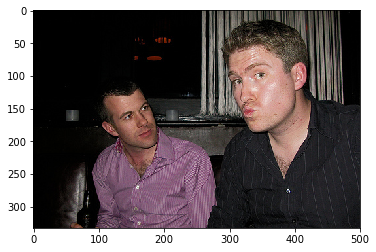

a man in a black shirt is holding a .
[1132, 1592, 1132, 2469, 1740, 2869, 1589, 1132]
[1132, 1592, 1132, 2095, 2469, 1784, 1132]
[1132, 1691, 1132, 2469, 1132]
[1132, 1132, 1132]
[1784]
[1132, 2585, 1592, 1132, 2722, 1132]
[1132, 1592, 1132, 1132]
[1132, 1132, 1846, 601, 1132, 188]
[1132, 1592, 1132, 2722, 1589, 601, 1132]
[1132, 2585, 1132, 1846, 1132]
[1132, 1132, 1589]
[1132, 1132]
[1132, 1132]
[]
[1132, 1132]
[1132, 1592, 1132, 1740, 1592, 1132]
[1132, 1132, 1740, 1132]
[1132, 1592, 1132, 1592, 1132]
[1132, 1592, 1132, 1592, 1132]
[1132, 1132, 1132]
[1132, 1132, 2221]
[1132, 1132]
[1589, 2221]
[1132, 1691, 1132, 2221]
[1132, 280, 974, 1132, 2221]
[1132, 1665, 1132, 2722, 1589, 680, 1132, 2469]
[1132, 1665, 1551, 1132, 1589, 680, 1132, 2469]
[1132, 1665, 1551, 1132, 1589, 680, 1132]
[1132, 1665, 1551, 1132, 2722, 1132]
[1132, 1665, 1132, 680, 1132]
[]
[1132, 1132]
[1589]
[]
[]
[1132, 1592, 1132, 1132]
[1592]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1132]

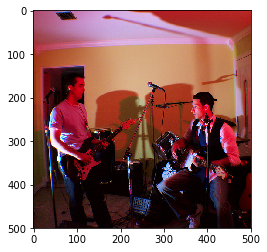

a man in a black shirt is playing a guitar .
[1132, 1691, 1589, 1132]
[1691]
[1132, 1691, 601, 1132]
[1132, 1691, 1589, 1132]
[1132, 1691, 1589, 1132]
[1691]
[1132, 1691, 1132]
[1132, 1132]
[1132, 1132]
[1132, 1691, 1132]
[1132, 1592, 1132, 1132, 1592, 1132, 859, 2221]
[1132, 1132, 2469, 1132, 1132, 2095, 280, 974, 859, 2221]
[1132, 1132, 2469, 1132, 1132, 974, 859, 2221]
[1132, 1592, 1132, 1132, 1592, 1132, 974, 859, 2221]
[1132, 1691, 1132, 1132, 1132, 2095]
[1132, 1691, 1592, 1132, 2722, 1589, 597, 1132]
[1691, 1592, 2722, 1589, 597]
[1589]
[]
[1132, 1691, 1592, 1132, 2722, 1589, 597, 1132]
[1132, 1691, 1592, 1132, 2722, 1589, 1132]
[1132, 1691, 1592, 1132, 1132]
[1132, 1691, 1592, 1132, 2462, 2722, 1589, 1132]
[1132, 1691, 1592, 1132, 2722, 1132]
[1132, 1691, 1592, 1132, 1132]
[1132, 1691, 1592, 1132, 597, 1132]
[1132, 1132, 1589, 1132]
[1132, 1132, 1589, 1132]
[1132, 1592, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132]
[1132, 1691, 1132]
[1132, 1132]
[1132, 1132]
[1132, 1691, 1132]
[

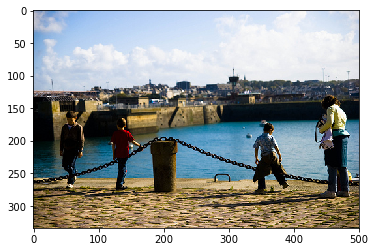

a man in a blue shirt is fishing on a pier .
[]
[]
[]
[]
[]
[1783]
[]
[1132, 1132, 1132]
[1132, 1592, 1132, 1132]
[]
[1132, 1592, 1132, 1132, 1132, 1592, 1132]
[1132, 1691, 1592, 1132, 1132, 1132, 1691, 1592, 1132]
[1132, 1691, 1132, 1132, 1132, 1691, 1132]
[1132, 1592, 1132, 1132, 1132, 1592, 1132]
[1132, 1132, 1132, 1132, 1132]
[1132, 1132, 1740, 1589, 1132]
[1132, 1592, 1132, 1740, 2722, 1132]
[1132, 1592, 1132, 1740, 2722, 1132]
[1132, 1592, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1691, 1589, 1132, 601, 1132]
[1132, 1132, 1132]
[1132, 1132, 601, 1132]
[1132, 1691, 1132, 1132]
[1132, 1691, 1132, 601, 1132]
[1132, 1691, 1589, 1132, 2469, 900, 1132]
[1132, 1589, 601, 1132, 2469, 1132]
[1132, 1691, 601, 1132, 900, 1132]
[1132, 601, 1132, 1132]
[1691, 2469]
[1132, 1132, 601, 1132]
[]
[1132, 1132, 601, 1132]
[1132, 1132, 1132]
[]
[1132, 1592, 1132, 1589, 1132, 1096]
[1132, 1592, 1132, 1589, 1132]

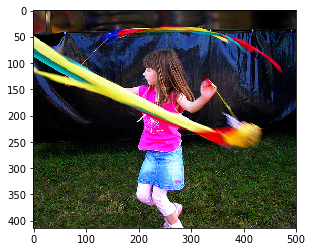

a man in a red shirt is holding a flag .
[601]
[1132, 1132, 601, 1132]
[1132, 1132, 601, 1132]
[1132, 1132, 1132]
[]
[1132, 1846, 601, 1132]
[1132, 573, 1589, 1846, 601, 1132]
[1132, 573, 1132]
[1132, 1132]
[1132, 1846, 601, 1132]
[1132, 1888, 1132, 2491]
[1132, 1132, 2491]
[1888]
[1888]
[1888]
[]
[1132, 1592, 1132, 1592, 1329, 2547, 1132]
[1592, 1592]
[1592, 1592]
[]
[1132, 1592, 1132, 2223, 601, 1132]
[1592, 2223]
[1132, 1592, 1132, 2223, 1589, 601, 1132]
[1132, 1592, 1132, 1783, 1132]
[1132, 573, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1132, 1132]
[]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 1592, 1132]
[1132, 2585, 1592, 1132, 1592, 1132]
[1592, 1592]
[1132, 1592, 1132, 1592, 2547, 1132]
[1592, 1592]
[1132, 1132, 1132, 601, 1132]
[1132, 1132, 1132, 1132]
[1132, 1132, 1589, 1132, 1132]
[1132, 1132, 1589, 1132, 1132]
[]
[1132, 1132, 1132]
[1592]
[]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1691, 1592, 1132, 1589, 280, 859]
[1132, 1691, 1592, 1132, 15

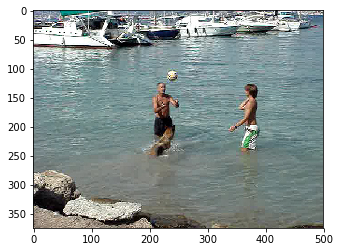

a man is standing on a beach with a surfboard .
[1132, 1691, 1592, 1132, 394, 1132, 1132, 601]
[1132, 1691, 1592, 1132, 2722, 1589, 1132, 1132, 601]
[1132, 1691, 1592, 1132, 280, 1132, 354, 1132, 601]
[1589]
[601]
[1132, 1592, 1132, 2722]
[1132, 1132, 1589, 859]
[1132, 1132, 1589]
[1132, 1132, 859]
[1132, 1132]
[1132, 1592, 1132, 2722, 1589, 859]
[1132, 1592, 1132]
[1132, 1592, 1132, 1589]
[1132, 1132]
[]
[1132, 1592, 1132, 601, 1132]
[1132, 1592, 1132, 601, 1132]
[1132, 1592, 1132, 601, 1132]
[1132, 1592, 1132, 1589, 1132]
[1132, 1592, 1132, 1589, 1132]
[1132, 1589, 1592, 1132]
[1132, 1691, 1132, 939]
[1132, 1691, 1592, 1132, 939]
[1132, 1592, 1132, 939]
[1132, 1691, 1589, 1132]
[1132, 1691, 1592, 1132, 1740, 2722, 2469, 1035, 1589, 859, 2221]
[1132, 1691, 1592, 1132]
[1691, 974]
[1132, 1691, 1592, 1132, 2469]
[1132, 1691, 1592, 1132, 1740, 2722]
[1132, 1592, 1132, 2223, 2722, 1589, 1132]
[1132, 1691, 1592, 1132, 2722, 1132]
[1132, 1592, 1132, 1589, 1132]
[1132, 1691, 1592, 1132, 2722

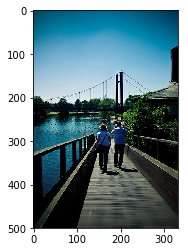

a man is fishing on a pier .
[1132, 1592, 1132, 1132, 382, 1132]
[1132, 1592, 1132, 1589, 1132, 1132]
[1132, 1132, 1132, 382, 1132]
[1132, 1132, 1589, 1132, 1132]
[1132, 1592, 1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 601, 1132]
[1132, 1132, 601, 1132]
[1132, 1132, 2223, 1132]
[1132, 1132, 1132]
[1132, 1132, 1846, 601, 1132]
[]
[1132, 1132, 1846, 601, 1132]
[1132, 1592, 1132, 1846, 1132]
[1132, 1132, 1132]
[1132, 1132, 1589, 1132]
[1132, 1592, 1132, 2722, 1589, 1132]
[1132, 1132, 1132]
[]
[1132, 1592, 1132, 1132]
[1132, 1132, 1589, 1132, 2547, 2559]
[1132, 1132, 2722, 1589, 1132, 2547]
[1132, 1592, 1132, 2722, 1132, 2547]
[1132, 1132, 1132, 2547]
[1132, 1132, 1589, 1132]
[1132, 1132, 597, 1132]
[1132, 1132, 1132]
[1132, 1132, 597, 1132]
[1132, 1132, 2547, 1132]
[1132, 1132, 597, 2547, 1132]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1132]
[1592]
[1132, 1592, 1132, 1132]
[]
[1132, 1132, 1132, 2547, 1132]
[1132, 1132, 601, 1132, 2547, 1132]
[1132, 1132, 1132, 1132]
[1132, 1132, 

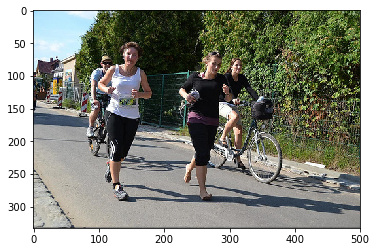

a man in a black shirt and a helmet is riding a bicycle down a dirt road .
[1132, 1132, 1132, 1132]
[1132, 1592, 1132, 1132, 1132]
[1132, 1592, 1132, 1132, 1132]
[1132, 1132, 1132, 1589, 1132]
[1132, 1132, 1132, 1132]
[1132, 1592, 1132, 2469, 2223, 1132, 2469]
[1132, 1132, 2095, 1132, 2095]
[1132, 1132, 1132]
[1132, 1592, 1132, 1132]
[1132, 1132, 1132]
[1132, 1589, 974, 1132]
[1132, 1589, 1132]
[1132, 72, 1589, 1132]
[1132, 1132]
[1132, 72, 1589, 1132]
[1592]
[]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1132]
[]
[1132, 1592, 1132, 2223, 1132]
[1132, 1132, 1589, 1132]
[2223]
[]
[1132, 1132, 1132]
[]
[1132, 1592, 1132, 2462, 1589, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 1589, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 1589, 1132]
[1132, 1592, 1132, 1589, 1132]
[1132, 1592, 1132, 1589, 1132]
[1132, 1132, 1589, 1132]
[1132, 1592, 1132, 1132]
[1592, 859, 601]
[1132, 1691, 1589, 1592, 859, 601, 1132]
[1132, 1592, 859, 1132]
[1132, 846, 1132]
[859]
[1132, 1132, 1589, 1132]
[1132, 1132,

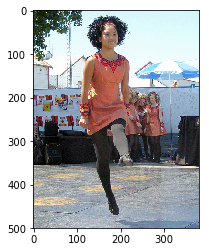

a woman in a white shirt is walking down the street .
[1132, 1691, 1592, 1132, 1592, 1132, 2351]
[1132, 1691, 1592, 1132, 1592, 1329, 2547, 1132]
[1132, 1132, 1132]
[1132, 1691, 1132, 1132, 2351]
[1132, 1132, 1589, 1132]
[1132, 1589, 859]
[1132, 1545, 859]
[1132, 1545, 859]
[1132, 1545, 1589, 859]
[1589, 859]
[1132, 1132, 1132]
[1132, 1691, 1592, 1132, 2462, 1589, 1132]
[1132, 1132, 1132]
[1132, 1691, 1132, 1589, 1132]
[1132, 1691, 1132, 1132]
[1132, 1132, 1132]
[1132, 1592, 1132, 1592, 1132]
[1132, 1592, 1132, 1592, 1132]
[1132, 1592, 1132, 1592, 1132]
[1132, 1592, 1132, 1592, 1132]
[1132, 1592, 1132, 1132]
[1132, 1592, 1132, 1589, 597, 1132]
[1132, 1592, 1132, 597, 1132]
[1132, 1592, 1132, 601, 1132]
[1132, 1132, 1132]
[1132, 1132, 2722, 1589, 1132, 2095, 2095]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1132, 1132]
[1132, 1691, 1592, 1132, 2462, 1132, 2547]
[1132, 1691, 1592, 1132, 1589, 1132, 2547]
[1132, 1592, 1132, 2462, 1589, 1132, 2547]
[1132, 1691, 1132, 24

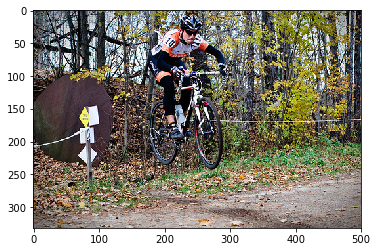

a man is riding a bicycle down a dirt road .
----------------------- Evaluation Results --------------------------
BLEU 1 : 0.604980407901 
BLEU 2 : 0.235112994724 
BLEU 3 : 0.0878830198001 
BLEU 4 : 0.0


In [5]:
test_and_eval(test_image_path='./data/flickr30k' ,model_path='./models/model-9')

In [6]:
ixtoword = np.load('./data/ixtoword.npy').tolist()
ixtoword[0]


'.'